Following the walkthrough at http://soft-matter.github.io/trackpy/dev/tutorial/walkthrough.html

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("figure", figsize=(10,5))
mpl.rc("image", cmap="gray")

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import pandas as pd

import pims
import trackpy as tp

# Importing data

In [54]:
path = '../data/beads/13.2_visc_PVP_0.4_um-40x/track_2/*.bmp'

frames = pims.as_gray(pims.open(path))
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/DanielBautista/Documents/Berkeley/Berkeley_Semester_5/Physics_111B/Lab_3/data/beads/13.2_visc_PVP_0.4_um-40x/track_2/*.bmp
    Length: 327 frames
    Frame Shape: (257, 257, 3)
    Pixel Datatype: uint8

Frame([[157.2069, 156.4915, 157.4194, ..., 129.6069, 129.5348, 128.8194],
       [135.743 , 136.4584, 138.5267, ..., 113.0981, 111.024 , 111.024 ],
       [156.131 , 156.131 , 155.6281, ..., 128.104 , 128.0319, 128.0319],
       ...,
       [105.5194, 106.379 , 106.5915, ...,  93.1511,  92.5799,  91.8645],
       [ 91.7318,  90.8722,  91.3751, ...,  82.0166,  81.3012,  81.0887],
       [104.5915, 104.7357, 104.7357, ...,  93.654 ,  93.0828,  92.5799]])
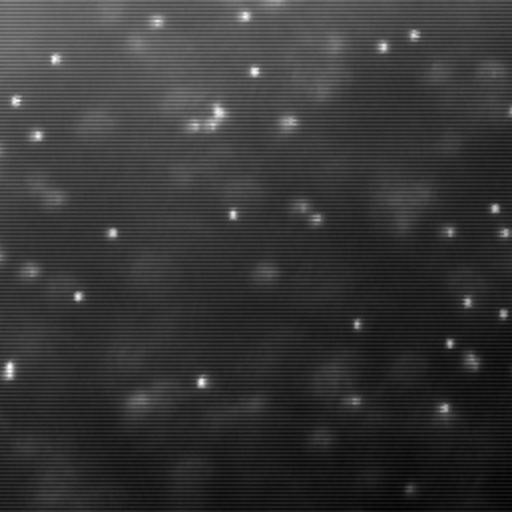

In [40]:
frames[0]

# Locating features

In [41]:
f = tp.locate(frames[0], diameter=11, minmass=500, maxsize=11)
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
4,7.740729,122.543051,792.499012,2.087493,0.115866,49.323544,12784.2246,0.159169,0
7,10.425333,78.476430,710.207919,2.417625,0.097469,33.734237,12731.3633,0.161788,0
11,17.145400,207.457018,761.064837,2.023037,0.060066,47.279045,11164.2521,0.315841,0
17,23.130668,191.947792,856.645176,2.026157,0.009581,52.134730,11518.0381,0.259959,0
21,29.195666,27.379397,813.710692,1.995205,0.032734,51.879168,12578.3297,0.169879,0


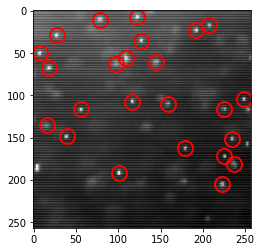

<AxesSubplot:>

In [42]:
tp.annotate(f, frames[0])

### Refining parameters to remove spurious features

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

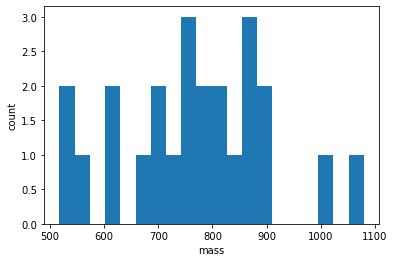

In [43]:
fig, ax = plt.subplots()
ax.hist(f["mass"], bins=20)

ax.set(xlabel="mass", ylabel="count")

In [44]:
# removing the high mass features
def mass_threshold(df, max_mass):
    df = df[df["mass"] < max_mass]
    return df

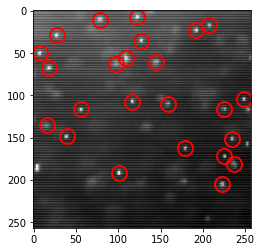

<AxesSubplot:>

In [45]:
f_new = mass_threshold(f, np.inf)
tp.annotate(f_new, frames[0])

### Check subpixel accuracy

The decimal part of x, y positions should be evenly distributed. If the mask size is too small, then the histogram will show a dip in the middle.

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

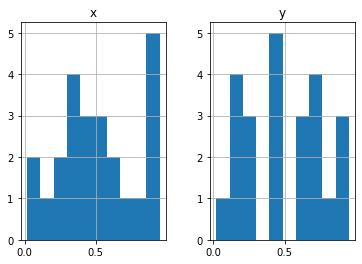

In [46]:
tp.subpx_bias(f)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

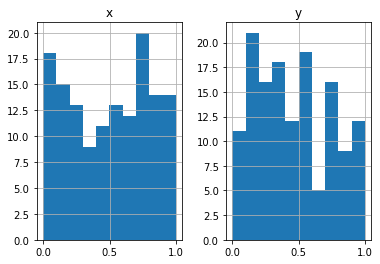

In [47]:
tp.subpx_bias(tp.locate(frames[0],11))

### Looking at several frames in a row

In [48]:
len(frames)

327

In [55]:
f = tp.batch(frames[:275], diameter=9, minmass=132, maxsize=3)

Frame 274: 42 features


# Linking features into particle trajectories

In [56]:
t = tp.link(f, search_range=10, memory=3)
t.head()

Frame 274: 42 trajectories present.


,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,7.700956,122.633270,591.120441,1.906114,0.095172,41.141078,8211.7748,0.126861,0,0
19,116.568392,56.051080,659.387505,1.823738,0.065160,49.730974,7136.0383,0.227770,0,1
20,135.727530,15.740269,319.408483,2.268277,0.080958,15.371392,6666.1167,0.349061,0,2
21,136.500669,134.783133,168.859262,2.489872,0.145796,7.459646,6003.7492,1.399561,0,3
22,148.440054,38.900371,669.333700,1.782026,0.010424,54.025922,7003.0956,0.252602,0,4


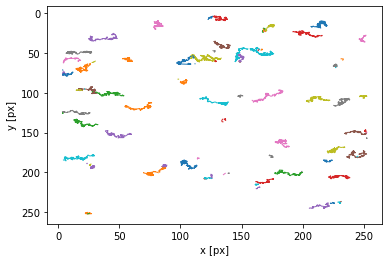

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [57]:
tp.plot_traj(t)

### Filtering spurious trajectories

We want to keep trajectories that persist for many frames and discard trajectories that only happen for a few frames. 

In [58]:
t1 = tp.filter_stubs(t, threshold=25)

print("Before:", t["particle"].nunique())
print("After: ",t1["particle"].nunique())

Before: 114
After:  54


We can also filter trajectories by their particle's appearance. We can look at a feature's "average appearance" throughout its trajectory.

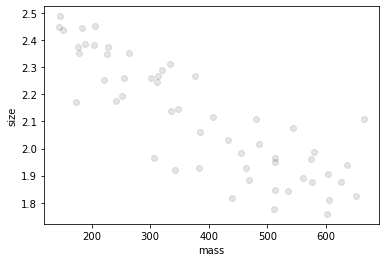

<AxesSubplot:xlabel='mass', ylabel='size'>

In [59]:
plt.figure()
tp.mass_size(t1.groupby("particle").mean())

### Removing overall drift

Compute the overall drifting motion, which will then be subtracted away, putting us in the reference frame of the particle's average position

In [60]:
d = tp.compute_drift(t1)

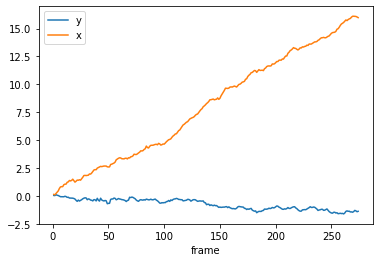

In [61]:
d.plot()
plt.show()

In [62]:
tm = tp.subtract_drift(t1.copy(), d)

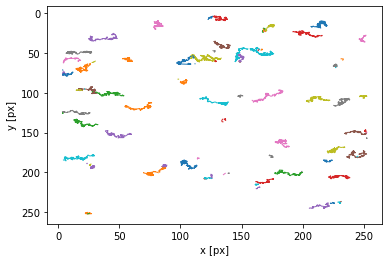

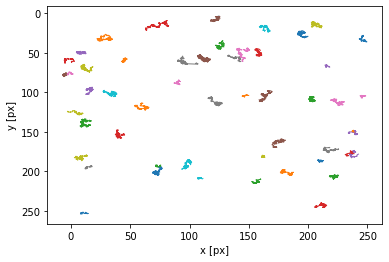

In [63]:
tp.plot_traj(t)
plt.show()
ax = tp.plot_traj(tm)
plt.show()

Obviously, for images containing particles with net movement in several directions, we will not have an overall bulk flow, and so, will not transform to the total comoving frame.

# Analyze trajectories

### Mean squared displacement of individual probes

In [64]:
im = tp.imsd(tm, 0.39625, 24)

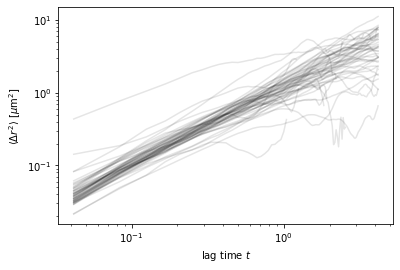

In [65]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

### Ensemble mean squared displacement

In [66]:
em = tp.emsd(tm, 0.1668, 24)

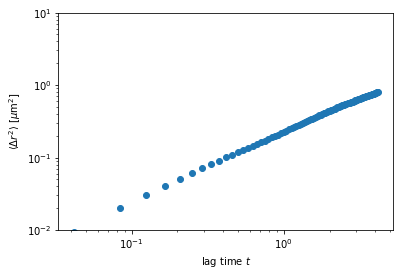

In [67]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(1e-2, 10));

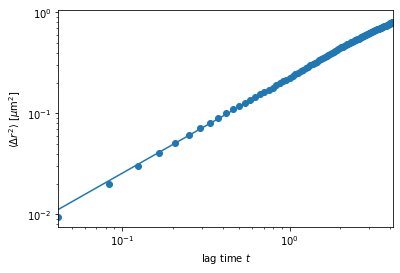

,n,A
msd,0.940525,0.222659


In [68]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
fits = tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]
fits

Calculating the dispersion coefficient from the fit results, where $$A = 4D$$

In [69]:
D = fits["A"][0]/4
D

0.05566467008596934

In [70]:
def percent_diff(theory, measured):
    return np.abs(theory - measured)/theory*100

In [71]:
percent_diff(0.081292, D)

31.5250331078466

Frame([[[ 86, 160, 149],
        [ 86, 161, 150],
        [ 87, 159, 150],
        ...,
        [ 76, 135, 129],
        [ 76, 135, 125],
        [ 74, 135, 125]],

       [[130, 119, 191],
        [130, 116, 189],
        [129, 115, 189],
        ...,
        [110, 103, 162],
        [110, 101, 162],
        [108, 100, 162]],

       [[ 86, 158, 147],
        [ 86, 159, 148],
        [ 87, 158, 148],
        ...,
        [ 76, 135, 126],
        [ 76, 135, 125],
        [ 74, 134, 125]],

       ...,

       [[ 66, 120, 111],
        [ 66, 120, 111],
        [ 66, 119, 111],
        ...,
        [ 58, 106,  98],
        [ 58, 106,  96],
        [ 57, 108,  96]],

       [[ 98,  86, 144],
        [ 98,  87, 143],
        [ 98,  87, 143],
        ...,
        [ 84,  77, 127],
        [ 84,  76, 126],
        [ 84,  77, 126]],

       [[ 65, 120, 111],
        [ 65, 119, 111],
        [ 64, 118, 111],
        ...,
        [ 56, 105,  98],
        [ 56, 104,  96],
        [ 56, 106,  96]]], dtype=uint8)
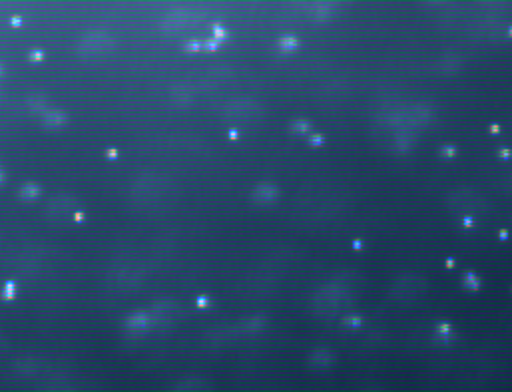

In [77]:
@pims.pipeline
def crop_img(image, crop):
    sh = image.shape
    return image[crop[0][0]:(sh[0]-crop[0][1]), crop[1][0]:(sh[1]-crop[1][1]), :]

frames = crop_img(pims.open(path), ((40,20), (0,0)))
frames[0]